In [1]:
%pylab inline
from qsystem_2 import PfbSoc, freq2reg
from tqdm import tqdm_notebook as tqdm
from qsystem2_asm import *
#from averager_program import AveragerProgram
from slab.instruments import InstrumentManager
import time


#qubit is on 229 ch 3
#readout is on 229 ch 2
#storage is on 229 ch 1
#JPA is on 229 ch 0

Populating the interactive namespace from numpy and matplotlib


Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'
Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


/usr/lib/python3/dist-packages/IPython/qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


In [2]:
# Load bitstream with custom overlay
soc = PfbSoc('qsystem_2.bit')
im=InstrumentManager(ns_address='192.168.14.1')
rLO=im['RF8']
#rLO.set_frequency(8.1516e9)
rLO.set_frequency(6.9516e9)

In [3]:
class AveragerProgram(ASM_Program):
    def __init__(self, cfg):
        ASM_Program.__init__(self)
        self.cfg=cfg
        self.make_program()
    
    def initialize(self):
        pass
    
    def body(self):
        pass
    
    def make_program(self):
        p=self
        
        rcount=12
        rjj=14

        p.initialize()
        p.regwi (0, rcount,0)
        p.regwi (0, rjj, self.cfg["reps"]-1)
        p.label("LOOP_J")

        p.body()

        p.mathi(0,rcount,rcount,"+",1)
        
        p.memwi(0,rcount,1)
                
        p.loopnz(0, rjj, 'LOOP_J')
       
        p.end()        
        
    def acquire(self, soc, load_pulses=True, progress=True):

        if load_pulses: 
            self.load_pulses(soc)
        # Readout configuration to route input without frequency translation.
        
        for readout,adc_freq in zip(soc.readouts,self.cfg["adc_freqs"]):
            readout.set_out(sel="product")
            readout.set_freq(adc_freq)
            #readout.dds_freq_reg=adc_freq
            #print (adc_freq)
        
        # Configure buffer capture.
        for avg_buf,adc_length in zip(soc.avg_bufs, self.cfg["adc_lengths"]):
            avg_buf.config_buf(address=0,length=adc_length)
            avg_buf.config_avg(address=0,length=adc_length)

            # Enable buffer capture.
            avg_buf.enable_buf()
            avg_buf.enable_avg()

        soc.tproc.load_asm_program(self)
        
        reps = self.cfg['reps']
        
        count=0
        last_count=0
        total_count=reps

        di_buf=np.zeros(total_count)
        dq_buf=np.zeros(total_count)
        
        soc.tproc.stop()
        
        soc.tproc.single_write(addr= 1,data=0)
        self.stats=[]
        
        soc.tproc.start()
        
        last_nn=0
        while count<total_count-1:
#             nn = soc.tproc.single_read(addr= 1)
#             if nn<last_nn:
#                 wrap=1
#             else:
#                 wrap=0
#             count=(count//2**16+wrap)*2**16 + nn
#             last_nn=nn
            count = soc.tproc.single_read(addr= 1)
            if count>=min(last_count+1000,total_count-1):
                addr=last_count % soc.avg_bufs[1].AVG_MAX_LENGTH
                length = count-last_count
                length -= length%2
                di,dq = soc.get_accumulated(ch=1,address=addr, length=length)

                di_buf[last_count:last_count+length]=di[:length]
                dq_buf[last_count:last_count+length]=dq[:length]

                last_count+=length
                self.stats.append( (time.time(), count,addr, length))
#                 pbar.update(last_count-pbar.n)
                #print (count,addr, length)
                    
        self.di_buf=di_buf
        self.dq_buf=dq_buf
        
        avg_di=np.sum(di_buf)/(reps)/self.cfg['adc_lengths'][0]
        avg_dq=np.sum(dq_buf)/(reps)/self.cfg['adc_lengths'][0]
        avg_amp=np.sqrt(avg_di**2+avg_dq**2)
        
        return avg_di, avg_dq, avg_amp
    
    

# Resonator Spectroscopy

In [4]:
config={"res_ch":1,
        "adc_lengths":[1000,1000], "res_gain":8000,"res_phase":0,
        "relax_delay":10, "frequency": 1000
       }

class ResonatorSpectroscopyProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)
        
    def initialize(self):
        cfg=self.cfg   
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
        freq=self.freq2reg(cfg["frequency"])
        
        self.pulse(ch=cfg["res_ch"], pulse="measure", freq=freq, phase=0, gain=cfg["res_gain"],  length=self.cfg['readout_length'] , t= 0, play=False)
        #soc.tproc.single_write(addr=123, data=self.freq2reg(cfg["frequency"]))
        #self.memri(self.ch_page(cfg["res_ch"]),self.sreg(cfg["res_ch"],"freq"),123)
        self.synci(200)
    
    def body(self):
        cfg=self.cfg 
        #self.measure(ch=self.cfg["res_ch"],  length=self.cfg['readout_length'], play=True)
        self.trigger_adc(adc1=1, adc2=1)
        self.pulse(ch=cfg["res_ch"], play=True)
        self.sync_all()
        self.delay(self.us2cycles(self.cfg["relax_delay"]))        

499.96875 0.046875
{'start': 499.96875, 'step': 0.046875, 'expts': 100, 'reps': 2000}


(-1, 50)

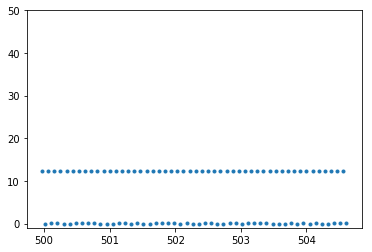

In [11]:
config={"res_ch":1,"reps": 2000,
        "readout_length":1000, "res_gain":5000,"res_phase":0,
        "relax_delay":10, "frequency": 1100
       }
rspec=ResonatorSpectroscopyProgram(config)
fstep=rspec.reg2freq_adc(1)
fstart=rspec.adcfreq(500)
print (fstart,fstep)

sweep_cfg={"start":1090, "step": .1, "expts":200, "reps": 2000}
#sweep_cfg={"start":90, "step": .1, "expts":200, "reps": 2000}
#sweep_cfg={"start":rspec.freq2reg_adc(1090), "step": rspec.freq2reg_adc(0.1), "expts":200, "reps": 2000}
sweep_cfg={"start":fstart, "step":1*fstep, "expts":100, "reps": 2000}
print(sweep_cfg)
#reg_pts=sweep_cfg["start"]+sweep_cfg["step"]*arange(sweep_cfg["expts"])
#fpts=[rspec.reg2freq_adc(f) for f in reg_pts]
rspec=ResonatorSpectroscopyProgram(config)
fpts=sweep_cfg["start"]+sweep_cfg["step"]*arange(sweep_cfg["expts"])
#fpts=[rspec.adcfreq(f) for f in fpts]
results=[]
for f in tqdm(fpts):
    #time.sleep(0.1)
    #config["frequency"]=rspec.reg2freq_adc(reg)
    #config["adc_freqs"]=[int(reg)]*2
    config["frequency"]=f #rspec.adcfreq(f)
    config["adc_freqs"]=[f,f]
    rspec=ResonatorSpectroscopyProgram(config)
    results.append(rspec.acquire(soc))
plot(fpts,np.array(results).T[2],'.')
ylim(-1, 50)